# Encoder-Decoder vs nn.Transformer Testing

### Create Dataloaders

In [1]:
# # %reload_ext autoreload
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append("..")

# from basic_transformer import TransformerEncDec
from basic_tokenizers import ByteTextTokenizer
from helpers import total_params

from fastai.text.all import *
from fastai.basics import *

In [2]:
path = Path('..')
df = pd.read_csv(path/'en_ga_prep.csv', index_col=0)
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [3]:
df = df.iloc[:100000,:]

In [4]:
#df = df[:32]

bs = 64

def add_eos(text):
    return text + f' {EOS}'

dblock = DataBlock(blocks=(TextBlock.from_df('en', tok_text_col='en', rules=[add_eos]),
                           TextBlock.from_df('ga', tok_text_col='ga', rules=[add_eos])),
                   get_x=ColReader('en'),
                   get_y=ColReader('ga'), 
                   splitter=RandomSplitter())

dsets = dblock.datasets(df)

pad_seq2seq = partial(pad_input, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, dl_type=SortedDL, before_batch=pad_seq2seq)
dls.show_batch(max_n=4)

/home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"( 6 ) In this section “ personal reliefs ” means any relief under section 32 of the Income Tax Act , 1918 , under sections 16 , 18 , 19 , 20 , 21 , 22 , and 23 of the Finance Act , 1920 , under section 4 of the Finance Act , 1951 ( No . 15 of 1951 ) , or under section 3 of the Finance Act , 1954 ( No . 22 of 1954 ) . xxeos","( 6 ) San alt seo , ciallaíonn “ faoisimh phearsanta ” aon fhaoiseamh faoi alt 32 den Income Tax Act , 1918 , faoi ailt 16 , 18 , 19 , 20 , 21 , 22 agus 23 den Finance Act , 1920 , faoi alt 4 den Acht Airgeadais , 1951 ( Uimh . 15 de 1951 ) , nó faoi alt 3 den Acht Airgeadais , 1954 ( Uimh . 22 de 1954 ) . xxeos xxpad xxpad"
1,"( 4 ) Where section 8 ( 5 ) of the Capital Gains Tax Act , 1975 , or section 13 ( 5 ) of the Corporation Tax Act , 1976 , has effect in respect of the disposal ( not being a relevant disposal ) of an asset , in an accounting period of a company , by an accountable person , then , notwithstanding any provision of the Corporation Tax Acts— xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( 4 ) I gcás éifeacht a bheith le halt 8 ( 5 ) den Acht um Cháin Ghnóchan Caipitiúil , 1975 , nó le halt 13 ( 5 ) den Acht Cánach Corparáide , 1976 , i leith diúscairt ( nach diúscairt iomchuí ) sócmhainne ag duine cuntasach i dtréimhse chuntasaíochta cuideachta , ansin , d'ainneoin aon fhoráil de chuid na nAchtanna Cánach Corparáide— xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"( 4 ) For the purposes of this section , “ business ” includes a trade , industry , profession or undertaking , or any activity carried on by a person or body of persons , whether corporate or unincorporate , or by a public or local authority or a Department of State , and the performance of its functions by a public or local authority or a Department of State . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( 4 ) Chun críocha an ailt seo , folaíonn “ gnó ” trádáil , tionscal , gairm nó gnóthas , nó aon ghníomhaíocht a sheolann duine nó comhlacht daoine , corpraithe nó neamhchorpraithe , nó a sheolann údarás poiblí nó údarás áitiúil nó Roinn Stáit , agus folaíonn sé comhlíonadh a fheidhmeanna ag údarás poiblí nó ag údarás áitiúil nó ag Roinn Stáit . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"( 2 ) A person who , on 31 March ( in this Act also referred to as the “ liability date ” ) of each year subsequent to the year 2009 , is the owner of a residential property shall be liable to pay the sum ( in this Act also referred to as a “ charge ” ) specified in subsection ( 3 ) to the relevant local authority . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( 2 ) Aon duine is úinéir ar mhaoin chónaithe an 31 Márta ( dá ngairtear an “ dáta dliteanais ” san Acht seo freisin ) de gach bliain tar éis na bliana 2009 , dlífear air nó uirthi an tsuim ( dá ngairtear “ muirear ” san Acht seo freisin ) a shonraítear i bhfo - alt ( 3 ) a íoc leis an údarás áitiúil iomchuí . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"


In [5]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

In [6]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768

xb, yb = dls.one_batch()
xb.shape, yb.shape

((64, 83), (64, 79))

In [7]:
en_vocab_sz, ga_vocab_sz

(10328, 16856)

## ActivationStats

Add more Activation Hooks

In [8]:
@patch
def hook(self:ActivationStats, m, i, o):
    if isinstance(o, tuple): return self.hook_multi_ouput(o)
    o = o.float()
    res = {'layer':m.__str__(), 'mean': o.mean().item(), 'std': o.std().item(),
           'near_zero': (o<=0.05).long().sum().item()/o.numel(), 
           'mean_inp': i[0].float().mean().item(), 'std_inp': i[0].float().std().item()}
    if self.with_hist: res['hist'] = o.histc(40,0,10)
    return res

@patch
def layer_stats(self:ActivationStats, idx):
    lstats = self.stats.itemgot(idx)
    return L(lstats.itemgot(o) for o in ('mean','std','near_zero','mean_inp','std_inp'))

@patch
def plot_layer_stats(self:ActivationStats, idx):
#     _,axs = subplots(1, 3, figsize=(12,3))
    _,axs = subplots(1, 5, figsize=(18,5))
    for o,ax,title in zip(self.layer_stats(idx),axs,('mean','std','% near zero', 'mean_inp','std_inp')):
        ax.plot(o)
        ax.set_title(title)

@patch
def color_dim(self:ActivationStats, idx, figsize=(18,10), ax=None):
    "The 'colorful dimension' plot"
    res = self.hist(idx)
    if ax is None: ax = subplots(figsize=figsize)[1][0]
    ax.imshow(res, origin='lower')
    ax.axis('off')

# Setup Models

Pytorch Model

In [8]:
class pt_PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class pt_TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = pt_PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [9]:
class dist_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, # d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True, activation='gelu'):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = pt_TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = pt_TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16

        self.final.weight = self.dec_tfmr_emb.embed.weight    # Tie Weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation=activation, custom_encoder=None, custom_decoder=None)
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(self.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                                         src_key_padding_mask=None, tgt_key_padding_mask=None, 
                                         memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        return out.permute(1,0,2)


Config

In [9]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768
n_heads = 8
d_ff = 2048

cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(),
       ActivationStats(every=2, with_hist=True)]

Basic Transformer

In [10]:
from basic_transformer import TransformerEncDec

# class dist_TransformerEncDec(nn.Module):

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=1, heads=n_heads, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

No module named 'axial_positional_embedding'


In [11]:
total_params(enc_dec_model)[0]

34289112

PT Model

In [12]:
pt_model = dist_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_ff,
                           n_enc_layers=1, n_dec_layers=1, n_heads=n_heads)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [13]:
total_params(pt_model)[0]

34289112

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

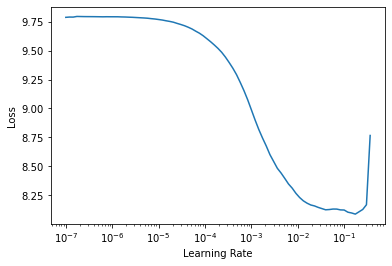

In [13]:
pt_learn.lr_find()

Learning rate suggested from Kaplan et al:

In [19]:
N=0
N += total_params(pt_model.transformer_model)[0]
N += total_params(pt_model.final)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00086, 0.00562)

# Testing

### Arto model

In [12]:
arto_encdec_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.293357    3.185129    0.344310  0.150669     08:18     


In [13]:
#arto_encdec_learn.fit_one_cycle(1, 1e-4, div=5)  

### Arto model - Encoder Causal Masking

In [13]:
arto_encdec_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.263313    3.159816    0.348824  0.154968     08:08     


In [11]:
arto_encdec_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.252599    3.142497    0.352849  0.156985     08:30     


### Pytorch model

In [15]:
pt_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.356841    3.297768    0.334849  0.135623     06:18     


PT Model - 2

In [13]:
pt_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.387500    3.315958    0.331393  0.134491     06:12     


# Activation Stats

## Basic Transformer

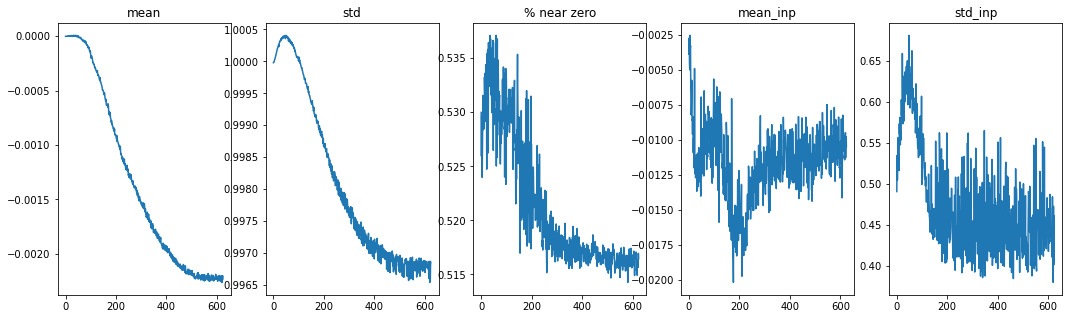

In [14]:
# ENCODER LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(5)

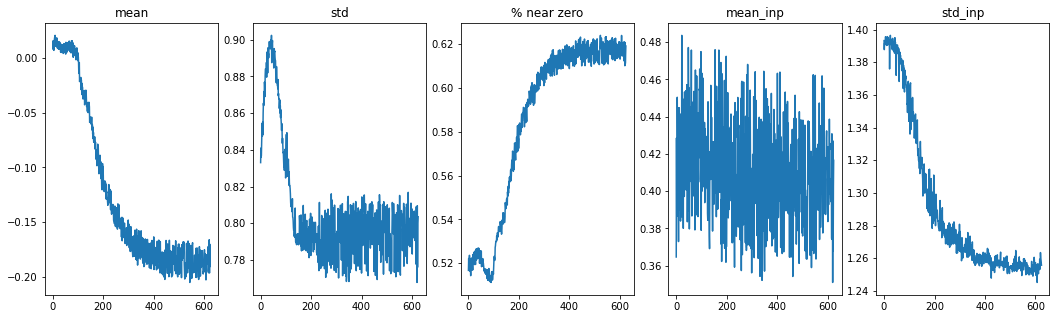

In [15]:
arto_encdec_learn.activation_stats.plot_layer_stats(6)

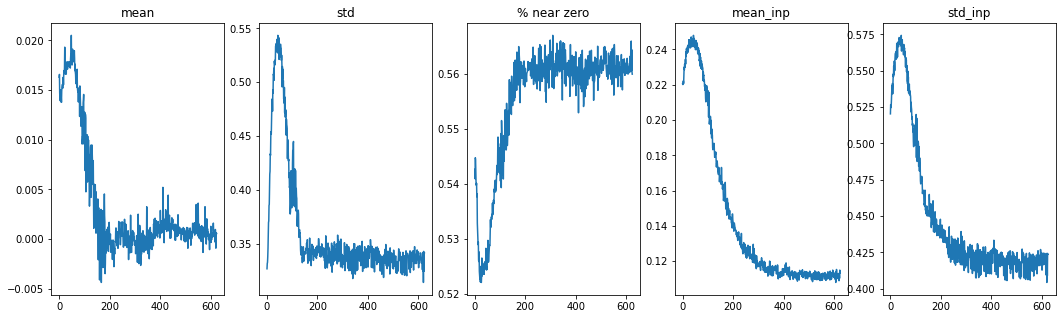

In [16]:
arto_encdec_learn.activation_stats.plot_layer_stats(7)

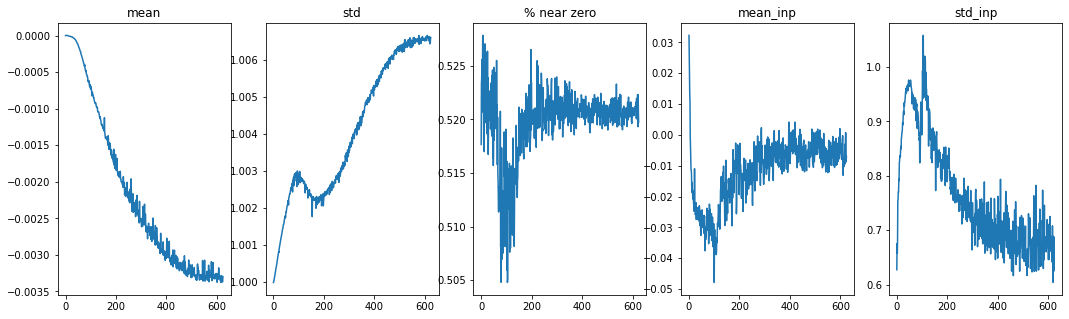

In [17]:
# Decoder LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(17)

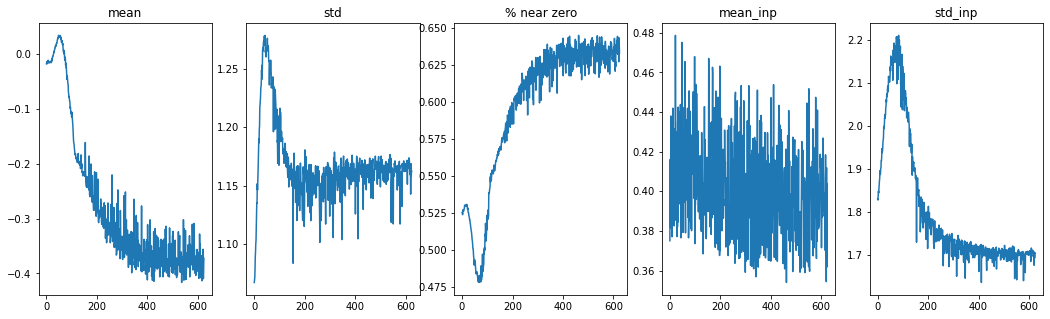

In [18]:
arto_encdec_learn.activation_stats.plot_layer_stats(18)

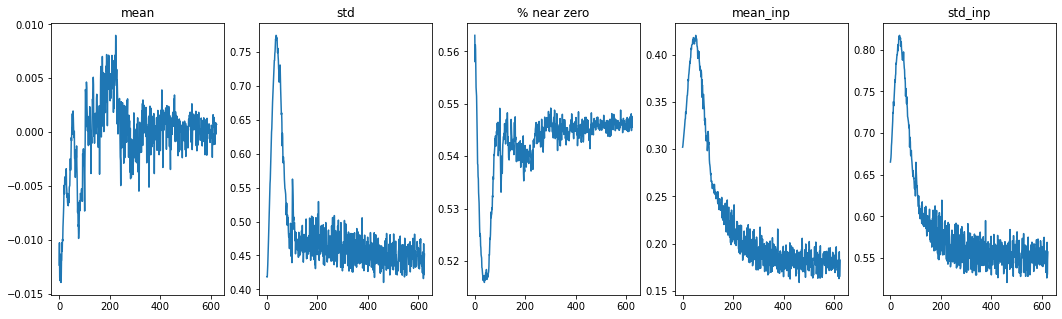

In [19]:
arto_encdec_learn.activation_stats.plot_layer_stats(19)

## Basic Transformer - Causal Masking

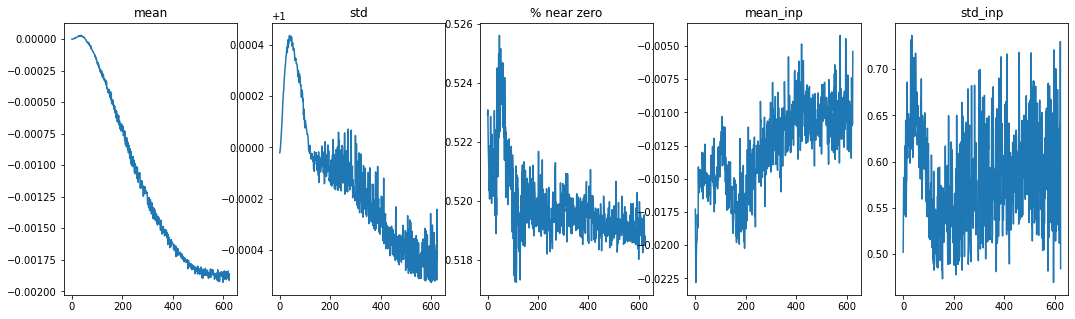

In [40]:
# ENCODER LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(5)

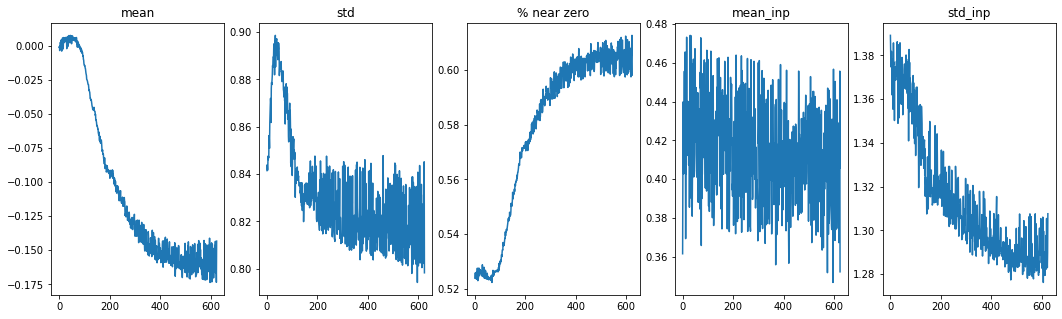

In [36]:
arto_encdec_learn.activation_stats.plot_layer_stats(6)

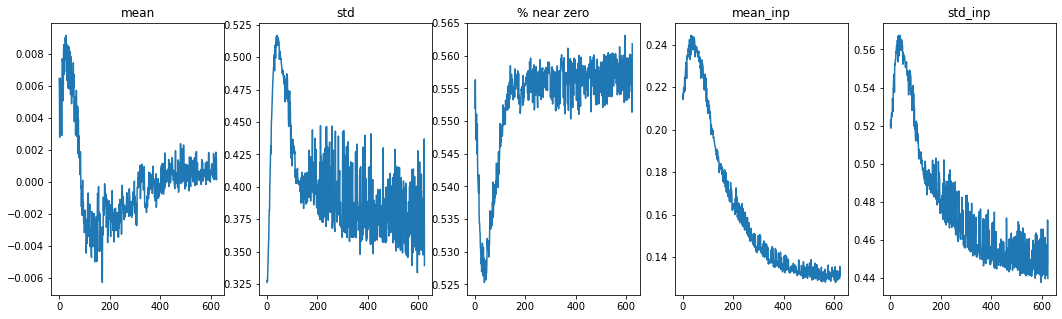

In [37]:
arto_encdec_learn.activation_stats.plot_layer_stats(7)

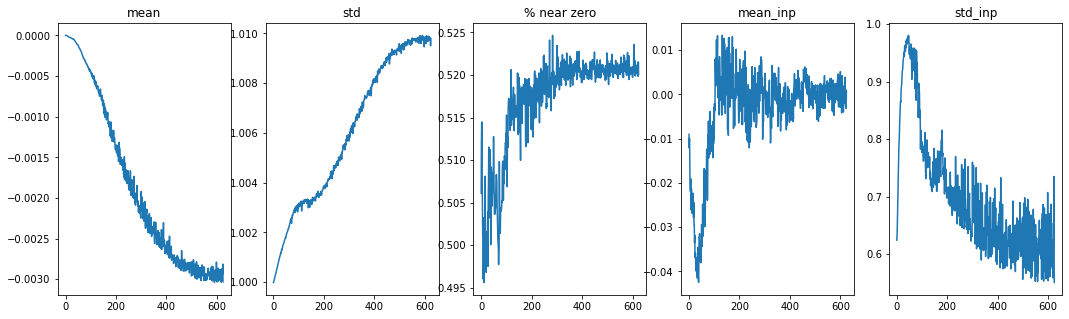

In [42]:
# Decoder LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(17)

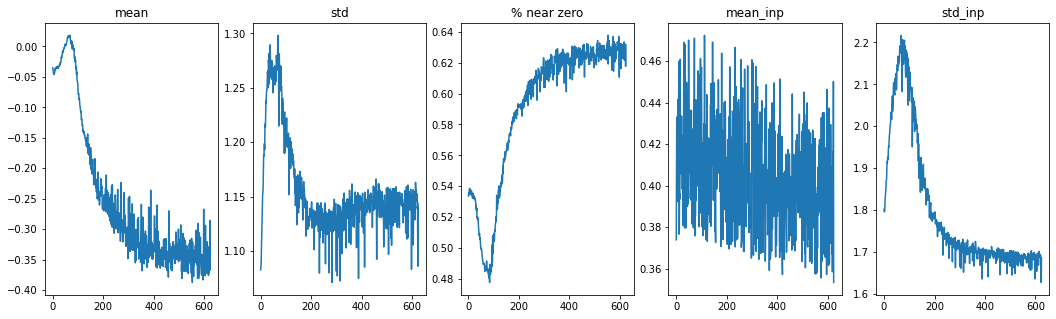

In [38]:
arto_encdec_learn.activation_stats.plot_layer_stats(18)

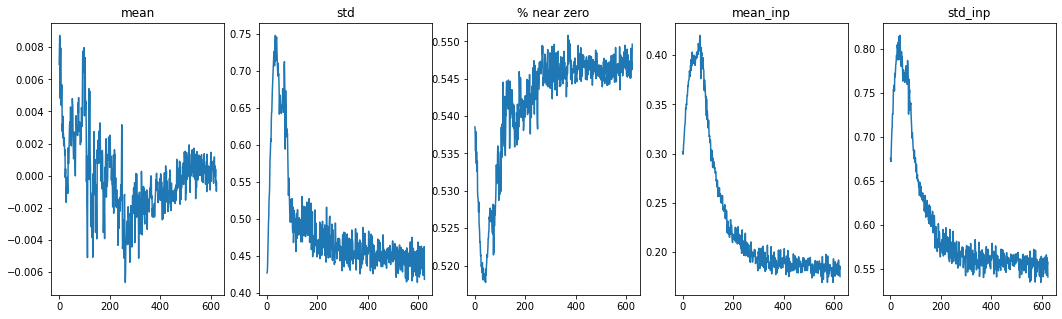

In [39]:
arto_encdec_learn.activation_stats.plot_layer_stats(19)

### Basic Transformer - Casual Masking 2

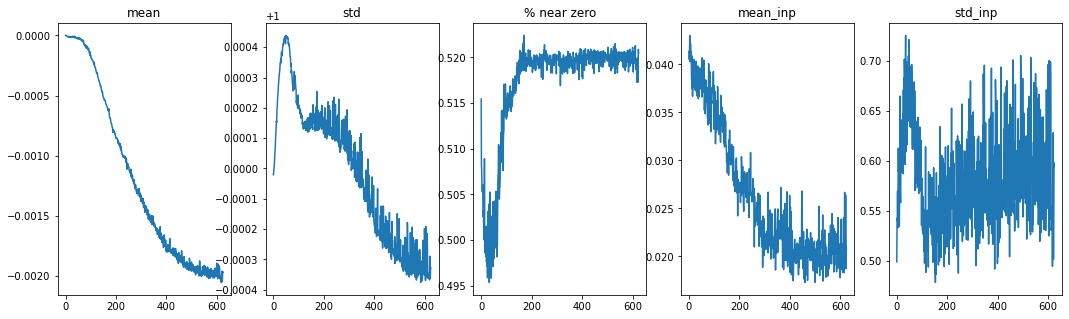

In [12]:
# ENCODER LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(5)

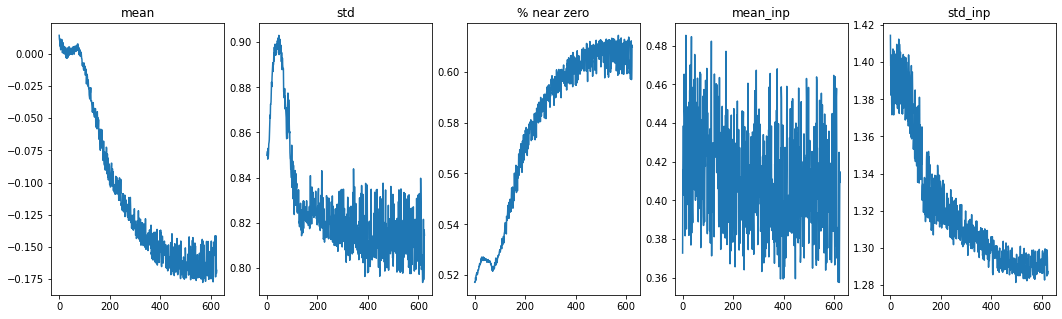

In [13]:
arto_encdec_learn.activation_stats.plot_layer_stats(6)

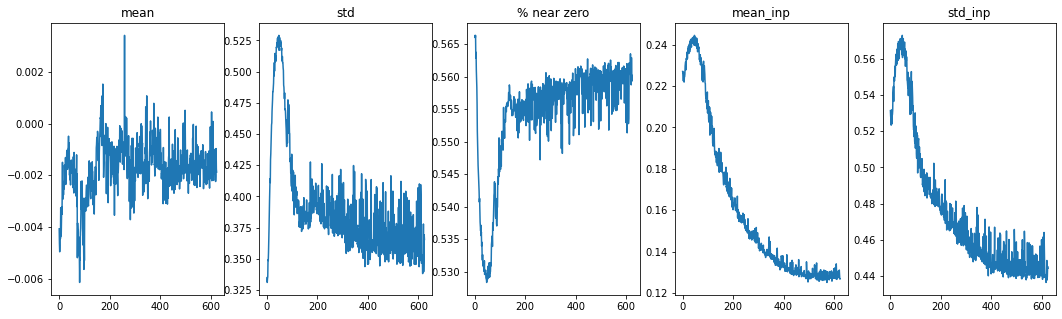

In [14]:
arto_encdec_learn.activation_stats.plot_layer_stats(7)

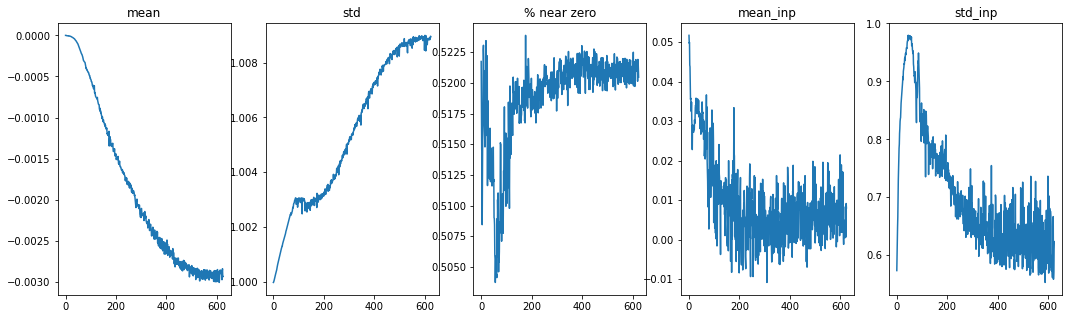

In [15]:
# Decoder LN AFTER ATTN
arto_encdec_learn.activation_stats.plot_layer_stats(17)

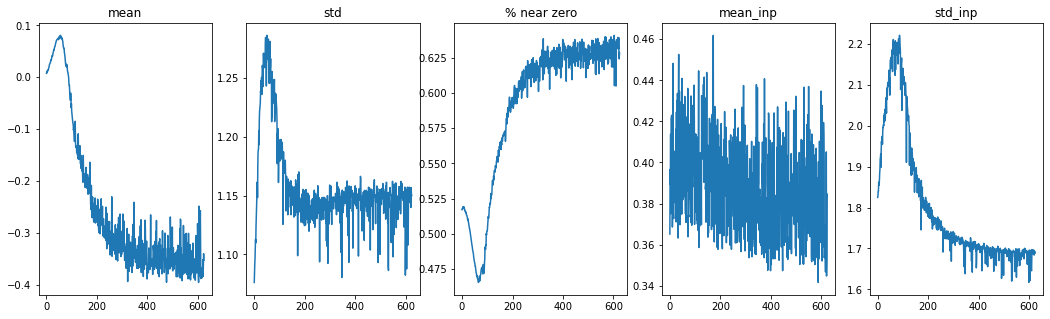

In [16]:
arto_encdec_learn.activation_stats.plot_layer_stats(18)

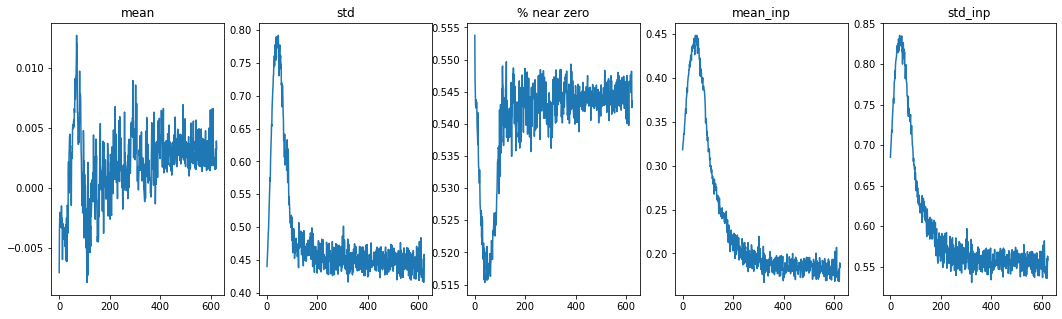

In [17]:
arto_encdec_learn.activation_stats.plot_layer_stats(19)

### PT

In [17]:
# pt_learn.activation_stats.plot_layer_stats(5)

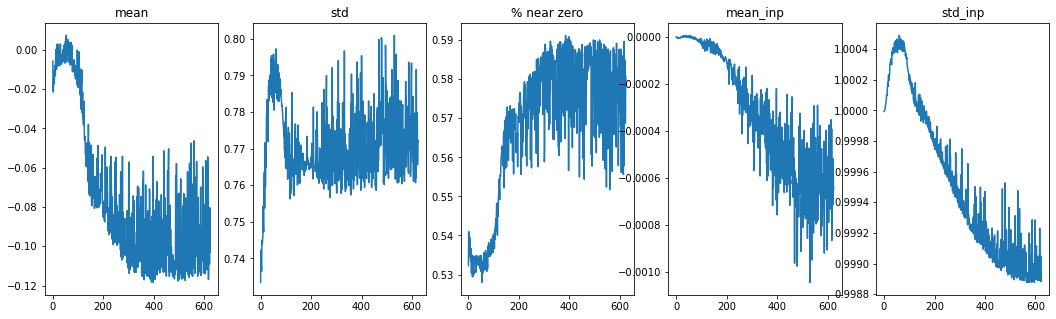

In [18]:
pt_learn.activation_stats.plot_layer_stats(6)

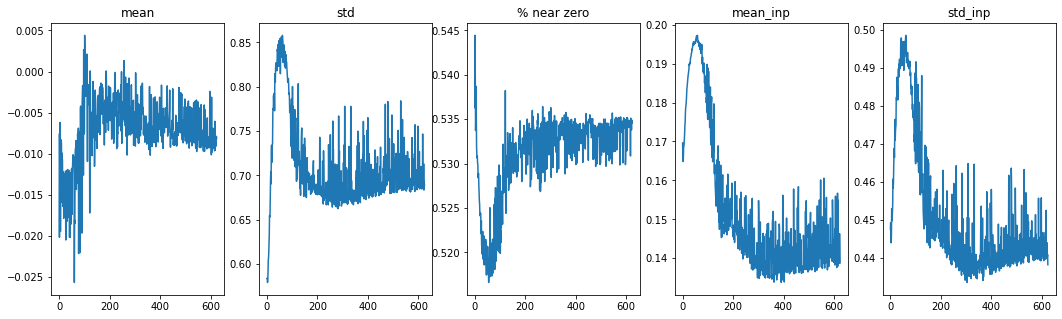

In [19]:
pt_learn.activation_stats.plot_layer_stats(7)

In [20]:
# pt_learn.activation_stats.plot_layer_stats(17)

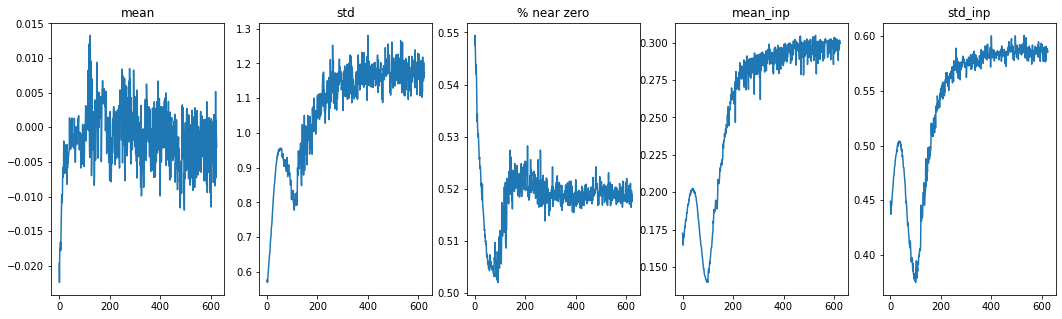

In [21]:
pt_learn.activation_stats.plot_layer_stats(18)

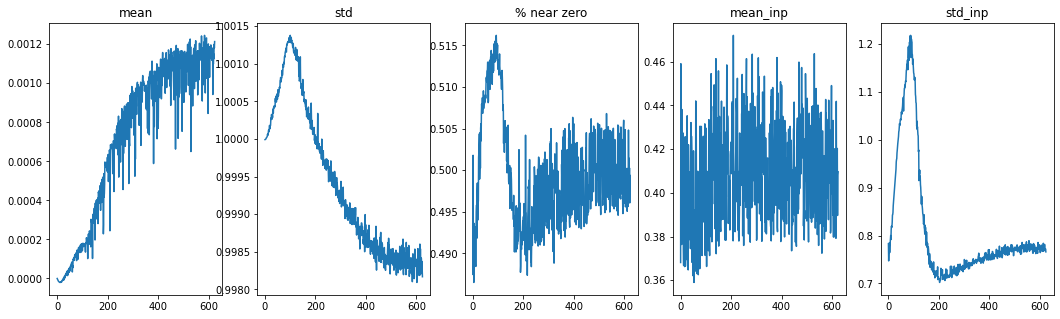

In [22]:
pt_learn.activation_stats.plot_layer_stats(19)

### PT - 2

In [17]:
# pt_learn.activation_stats.plot_layer_stats(5)

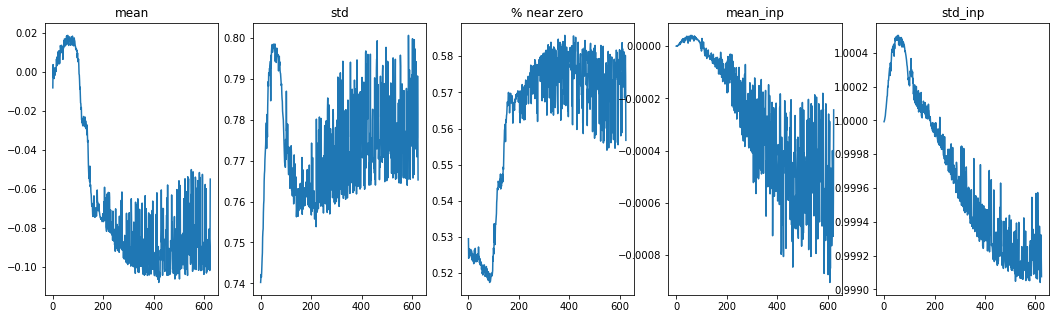

In [14]:
pt_learn.activation_stats.plot_layer_stats(6)

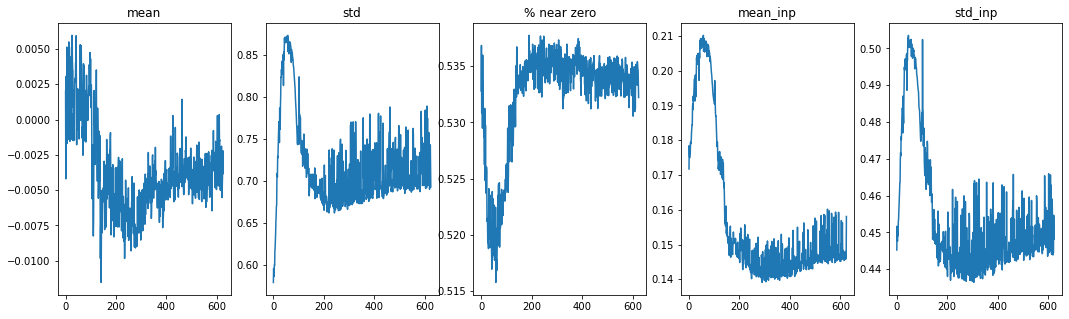

In [15]:
pt_learn.activation_stats.plot_layer_stats(7)

In [16]:
# pt_learn.activation_stats.plot_layer_stats(17)

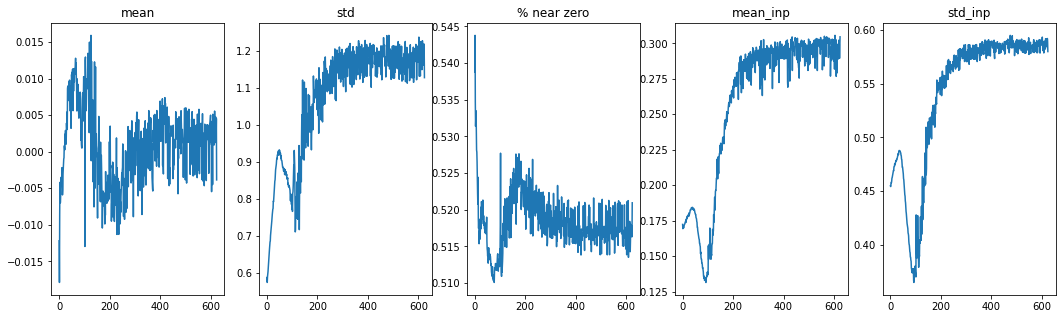

In [17]:
pt_learn.activation_stats.plot_layer_stats(18)

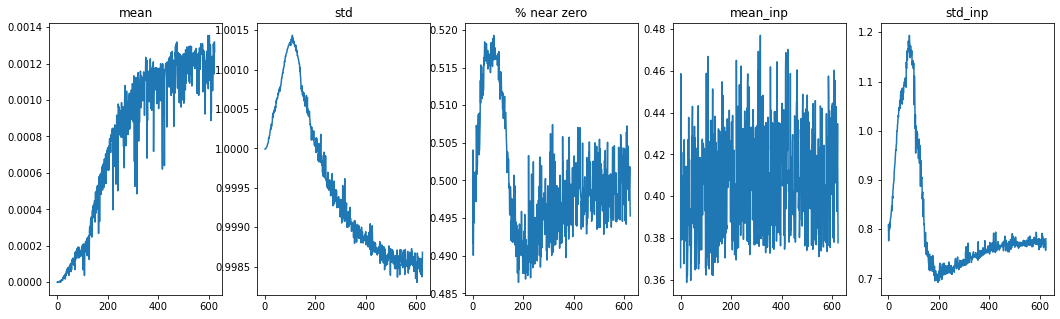

In [18]:
pt_learn.activation_stats.plot_layer_stats(19)

## Color Dim

### Basic Transformer

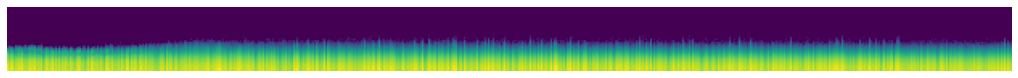

In [20]:
arto_encdec_learn.activation_stats.color_dim(5)    

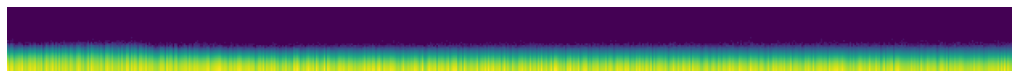

In [21]:
arto_encdec_learn.activation_stats.color_dim(6)    

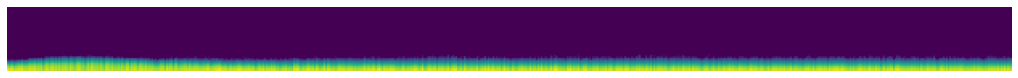

In [22]:
arto_encdec_learn.activation_stats.color_dim(7)    

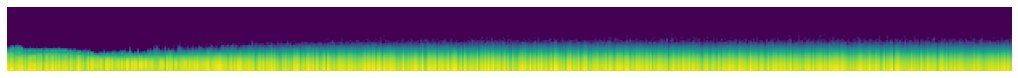

In [23]:
arto_encdec_learn.activation_stats.color_dim(17)    

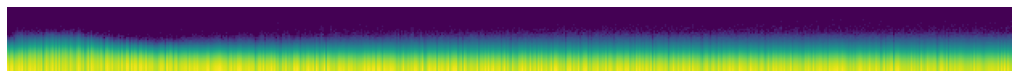

In [24]:
arto_encdec_learn.activation_stats.color_dim(18)    

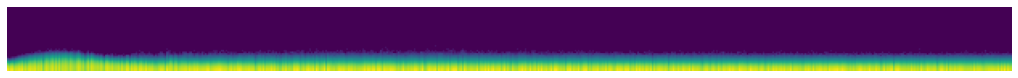

In [25]:
arto_encdec_learn.activation_stats.color_dim(19)    

### Basic Transformer - Causal Masking

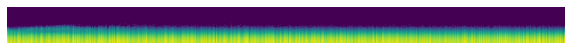

In [43]:
arto_encdec_learn.activation_stats.color_dim(5)    

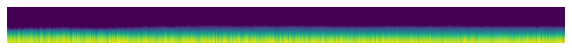

In [44]:
arto_encdec_learn.activation_stats.color_dim(6)    

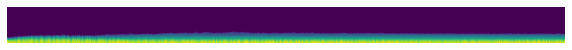

In [45]:
arto_encdec_learn.activation_stats.color_dim(7)    

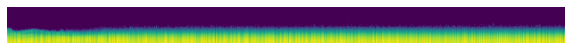

In [46]:
arto_encdec_learn.activation_stats.color_dim(17)    

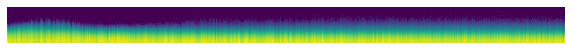

In [47]:
arto_encdec_learn.activation_stats.color_dim(18)    

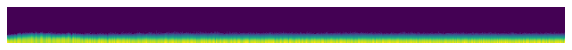

In [48]:
arto_encdec_learn.activation_stats.color_dim(19)    

### Basic Transformer - Causal Masking -  2

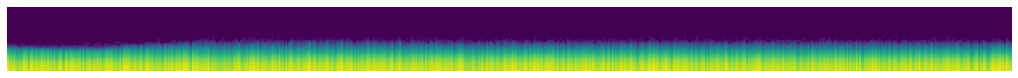

In [18]:
arto_encdec_learn.activation_stats.color_dim(5)    

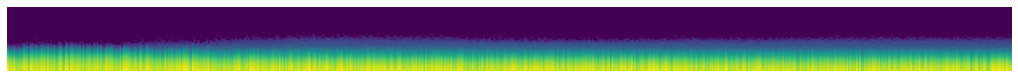

In [19]:
arto_encdec_learn.activation_stats.color_dim(6)    

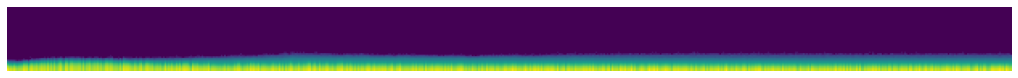

In [20]:
arto_encdec_learn.activation_stats.color_dim(7)    

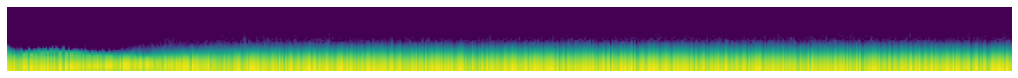

In [21]:
arto_encdec_learn.activation_stats.color_dim(17)    

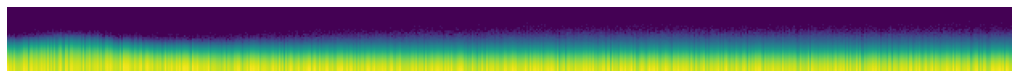

In [22]:
arto_encdec_learn.activation_stats.color_dim(18)    

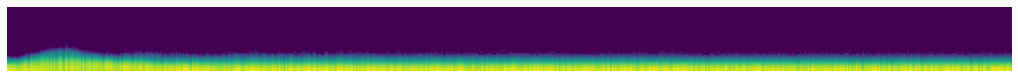

In [23]:
arto_encdec_learn.activation_stats.color_dim(19)    

### PT Color Dim

In [23]:
# pt_learn.activation_stats.color_dim(5)    

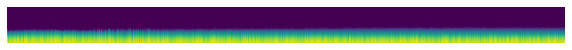

In [24]:
pt_learn.activation_stats.color_dim(6)    

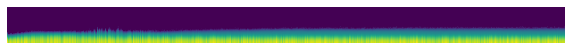

In [25]:
pt_learn.activation_stats.color_dim(7)    

In [26]:
# pt_learn.activation_stats.color_dim(17)    

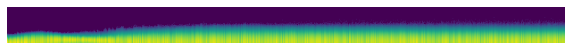

In [27]:
pt_learn.activation_stats.color_dim(18)    

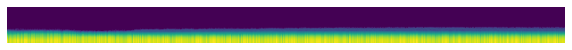

In [28]:
pt_learn.activation_stats.color_dim(19)    

### PT Color Dim 2

In [23]:
# pt_learn.activation_stats.color_dim(5)    

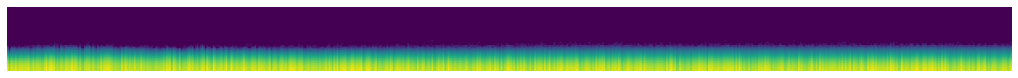

In [32]:
pt_learn.activation_stats.color_dim(6)    

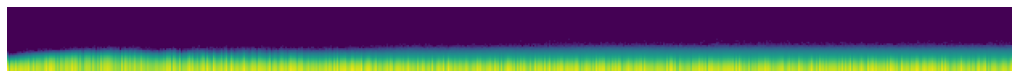

In [33]:
pt_learn.activation_stats.color_dim(7)    

In [34]:
# pt_learn.activation_stats.color_dim(17)    

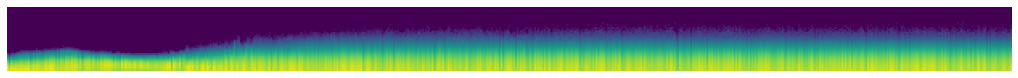

In [35]:
pt_learn.activation_stats.color_dim(18)    

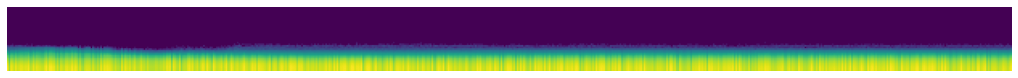

In [36]:
pt_learn.activation_stats.color_dim(19)    

In [101]:
len(pt_learn.activation_stats.stats)

75

pt enc ff layer 1: 6

pt enc ff layer 2: 7
    
pt dec ff layer 1: 17

pt dec ff layer 2: 18

art enc ff layer 1: 6

art enc ff layer 2: 7
    
art dec ff layer 1: 17

art dec ff layer 2: 18

In [ ]:
for l in pt_learn.activation_stats.stats:
#     print(l)
    for i,ll in enumerate(l): 
#         print(ll)
        print(i)
        if ll is not None: print(ll['layer'])
        else: print('None')
    print()
    #print(l['layer'])
    break

In [ ]:
art enc ff layer 1: 6

art enc ff layer 2: 7
    
art dec ff layer 1: 17

art dec ff layer 2: 18

In [ ]:
5 : output from attention
    
    

In [16]:
for l in arto_encdec_learn.activation_stats.stats:
#     print(l)
    for i,ll in enumerate(l): 
        print(i)
        print(ll['layer'])
    print()
    #print(l['layer'])
    break

0
Embedding(10328, 768)
1
Embedding(16856, 768)
2
Linear(in_features=768, out_features=768, bias=True)
3
Linear(in_features=768, out_features=1536, bias=True)
4
Linear(in_features=768, out_features=768, bias=True)
5
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
6
Linear(in_features=768, out_features=2048, bias=True)
7
Linear(in_features=2048, out_features=768, bias=True)
8
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
9
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
10
Linear(in_features=768, out_features=768, bias=True)
11
Linear(in_features=768, out_features=1536, bias=True)
12
Linear(in_features=768, out_features=768, bias=True)
13
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
14
Linear(in_features=768, out_features=768, bias=True)
15
Linear(in_features=768, out_features=1536, bias=True)
16
Linear(in_features=768, out_features=768, bias=True)
17
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
18
Linear(in_features=768, out_features=2048, bias=Tru